In [1]:
%load_ext autoreload

In [2]:
%autoreload
import os
import numpy as np
import pandas as pd
import time
import pickle
from tqdm.notebook import tqdm
from numpy.lib.format import open_memmap
#from pandarallel import pandarallel
from scipy.stats import multivariate_normal, entropy, pearsonr
from scripts.data import *
from scripts.preprocessing import *
from scripts.utils import *
from scripts.main import *
from scripts.saliency_metrics import *

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale = 1.3)
%matplotlib inline

In [4]:
# load et data
data_path    = './../data/ETFinalCutSampleEC07/ETFinalCutSample/'
results_path = './../results/'

df_wk = pd.read_csv(os.path.join(results_path, 'WK', 'results_nss_wk_dg.csv')) 
df_ff = pd.read_csv(os.path.join(results_path, 'FF', 'results_nss_ff_dg.csv'))
df_tp = pd.read_csv(os.path.join(results_path, 'TP', 'results_nss_tp_dg.csv'))

videos_df = {'Diary': df_wk, 'Fractals': df_ff, 'Present': df_tp}

# load video data
videos_data = load_video_data()
trials_data = load_trials_data()

# Limpieza de sujetos

In [5]:
pheno = pd.read_csv('./../data/PhenoDataFinal.csv')
pheno.head()

,Age,ID,Enroll_Season,Enroll_Year,Release_Number,Sex,CV_Score,med_type_01,med_type_02,med_type_03,...,DX_10_Sub,Site,EHQ_Total,Child_Race,SWAN_HY,SWAN_IN,SWAN_Total,WAIS_FSIQ_SCALE,WASI_FSIQ,WISC_FSIQ
0,6.72804,NDARAA075AMK,Summer,2016,1,1,14,NaN,NaN,NaN,...,NaN,2,65.54,NaN,-2.444444,-2.111111,-2.277777,.,.,140
1,5.545744,NDARAA112DMH,Fall,2016,1,0,14,NaN,NaN,NaN,...,NaN,1,40,2,.,.,.,.,.,.
2,7.475929,NDARAA117NEJ,Fall,2016,1,0,11,Non-Psychiatric Drug,NaN,NaN,...,NaN,1,62.2,2,0.555555,-1.111111,-0.277777,.,.,88
3,21.216746,NDARAA306NT2,Spring,2019,9,1,13,.,.,.,...,NaN,3,6.67,9,-1.666666,0,-0.833333,65,.,.
4,11.853296,NDARAA358BPN,Fall,2017,5,0,NaN,.,.,.,...,NaN,1,.,.,.,.,.,.,.,NaN


In [6]:
diagnosis_cols = pheno.columns[10:40]
pheno['DX_01_Cat'].unique()

array(['No Diagnosis Given', 'Neurodevelopmental Disorders',
       'Anxiety Disorders', 'No Diagnosis Given: Incomplete Eval',
       'Depressive Disorders',
       'Other Conditions That May Be a Focus of Clinical Attention',
       'Bipolar and Related Disorders', nan,
       'Obsessive Compulsive and Related Disorders',
       'Disruptive, Impulse Control and Conduct Disorders',
       'Trauma and Stressor Related Disorders', 'Elimination Disorders',
       '.', 'Neurocognitive Disorders',
       'Schizophrenia Spectrum and other Psychotic Disorders',
       'Feeding and Eating Disorders',
       'Substance Related and Addictive Disorders', 'Gender Dysphoria'],
      dtype=object)

In [7]:
pheno = pd.read_csv('./../data/PhenoDataFinal.csv')
diagnosis_valid = ['ADHD-Inattentive Type', 'ADHD-Combined Type', 'No Diagnosis Given'] #'ADHD-Hyperactive/Impulsive Type'
pheno_filtered = pheno[pheno['DX_01'].isin(diagnosis_valid)]
pheno_filtered = pheno_filtered[pheno_filtered['DX_01_Cat'] != 'No Diagnosis Given: Incomplete Eval']
pheno_filtered.Age = pheno_filtered.Age.astype(float)
pheno_filtered['DX_01_Cat'].unique()

array(['No Diagnosis Given', 'Neurodevelopmental Disorders'], dtype=object)

In [8]:
pheno_filtered.head() #check comorbilities

,Age,ID,Enroll_Season,Enroll_Year,Release_Number,Sex,CV_Score,med_type_01,med_type_02,med_type_03,...,DX_10_Sub,Site,EHQ_Total,Child_Race,SWAN_HY,SWAN_IN,SWAN_Total,WAIS_FSIQ_SCALE,WASI_FSIQ,WISC_FSIQ
0,6.728040,NDARAA075AMK,Summer,2016,1,1,14,NaN,NaN,NaN,...,NaN,2,65.54,NaN,-2.444444,-2.111111,-2.277777,.,.,140
1,5.545744,NDARAA112DMH,Fall,2016,1,0,14,NaN,NaN,NaN,...,NaN,1,40,2,.,.,.,.,.,.
2,7.475929,NDARAA117NEJ,Fall,2016,1,0,11,Non-Psychiatric Drug,NaN,NaN,...,NaN,1,62.2,2,0.555555,-1.111111,-0.277777,.,.,88
5,9.165297,NDARAA504CRN,Spring,2019,8,1,14,.,.,.,...,NaN,3,73.34,8,0.222222,0.555555,0.388888,.,.,100
6,11.998402,NDARAA536PTU,Spring,2016,1,0,14,.,.,.,...,NaN,2,-86.67,2,-0.111111,1,0.444444,.,.,116


In [9]:
# filter comorbilities
comorbilities = ['bla bla bla']
pheno_filtered.columns

Index(['Age', 'ID', 'Enroll_Season', 'Enroll_Year', 'Release_Number', 'Sex',
       'CV_Score', 'med_type_01', 'med_type_02', 'med_type_03', 'DX_01',
       'DX_01_Cat', 'DX_01_Sub', 'DX_02', 'DX_02_Cat', 'DX_02_Sub', 'DX_03',
       'DX_03_Cat', 'DX_03_Sub', 'DX_04', 'DX_04_Cat', 'DX_04_Sub', 'DX_05',
       'DX_05_Cat', 'DX_05_Sub', 'DX_06', 'DX_06_Cat', 'DX_06_Sub', 'DX_07',
       'DX_07_Cat', 'DX_07_Sub', 'DX_08', 'DX_08_Cat', 'DX_08_Sub', 'DX_09',
       'DX_09_Cat', 'DX_09_Sub', 'DX_10', 'DX_10_Cat', 'DX_10_Sub', 'Site',
       'EHQ_Total', 'Child_Race', 'SWAN_HY', 'SWAN_IN', 'SWAN_Total',
       'WAIS_FSIQ_SCALE', 'WASI_FSIQ', 'WISC_FSIQ'],
      dtype='object')

In [10]:
# select subjects for video
def filter_subjects(df, df_metadata):
    subjects = df.ID.unique()
    subjects_metadata = df_metadata.ID
    # intersection
    subjs = list(set(subjects) & set(subjects_metadata))
    print('Total subjects: %i'%len(subjs))
    return df.set_index('ID').loc[subjs,:]

## The Present

In [11]:
df_tp_filtered = filter_subjects(df_tp, pheno_filtered)
pheno_filtered.set_index('ID').loc[list(df_tp_filtered.index.unique()), 'DX_01'].value_counts()

Total subjects: 141


ADHD-Combined Type       64
ADHD-Inattentive Type    58
No Diagnosis Given       19
Name: DX_01, dtype: int64

Text(0.5, 1.0, 'Present')

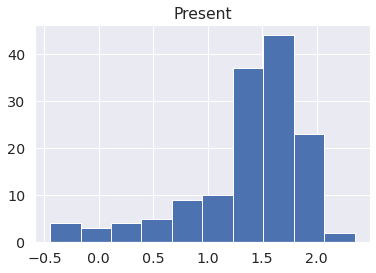

In [12]:
df_tp_filtered['NSS'].groupby('ID').mean().hist()
plt.title('Present')

Text(0.5, 1.0, 'Present')

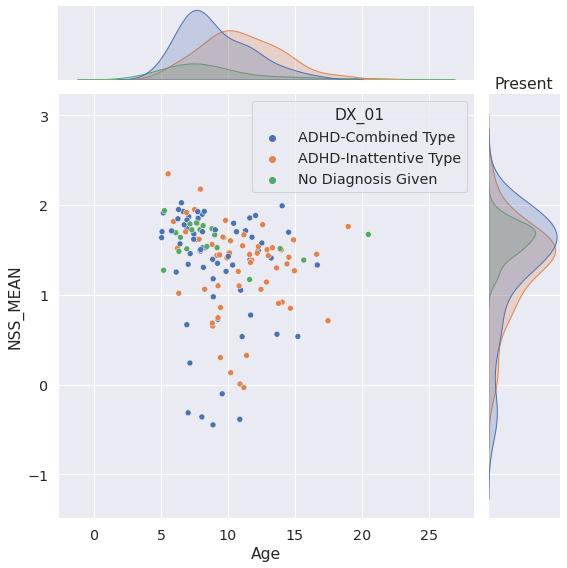

In [13]:
df_tp_diag = pd.merge(df_tp_filtered[~df_tp_filtered.index.duplicated(keep='first')], pheno_filtered[['ID','DX_01','Age']] , on='ID', how='inner').set_index('ID')
sns.jointplot(x='Age',y='NSS_MEAN', hue='DX_01', data=df_tp_diag, height=8);
plt.title('Present')

Text(0.5, 1.0, 'Present')

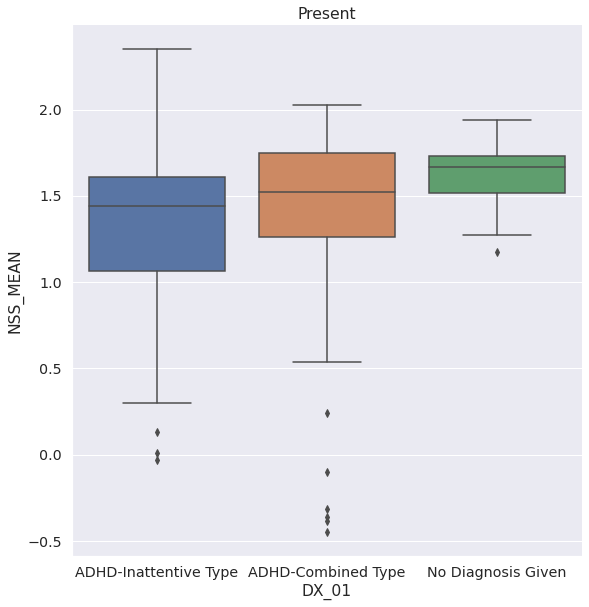

In [14]:
g = sns.catplot(x='DX_01',y='NSS_MEAN', data=df_tp_diag, height=8, kind='box', order=diagnosis_valid);
plt.title('Present')

## Wimpy Kid

In [15]:
df_wk_filtered = filter_subjects(df_wk, pheno_filtered)
pheno_filtered.set_index('ID').loc[list(df_wk_filtered.index.unique()), 'DX_01'].value_counts()

Total subjects: 492


ADHD-Combined Type       201
ADHD-Inattentive Type    150
No Diagnosis Given       141
Name: DX_01, dtype: int64

Text(0.5, 1.0, 'Diary')

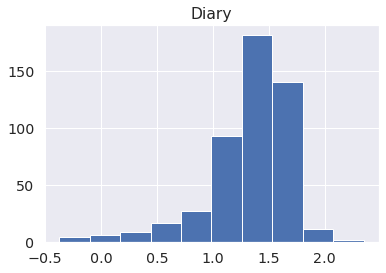

In [16]:
df_wk_filtered['NSS'].groupby('ID').mean().hist()
plt.title('Diary')

Text(0.5, 1.0, 'Diary')

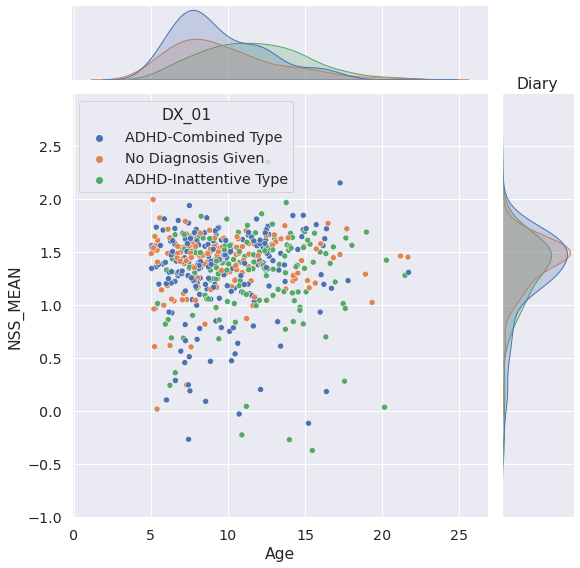

In [17]:
df_wk_diag = pd.merge(df_wk_filtered[~df_wk_filtered.index.duplicated(keep='first')], pheno_filtered[['ID','DX_01', 'Age']] , on='ID', how='inner').set_index('ID')
sns.jointplot(x='Age',y='NSS_MEAN', hue='DX_01',data=df_wk_diag, height=8);
plt.title('Diary')

Text(0.5, 1.0, 'Diary')

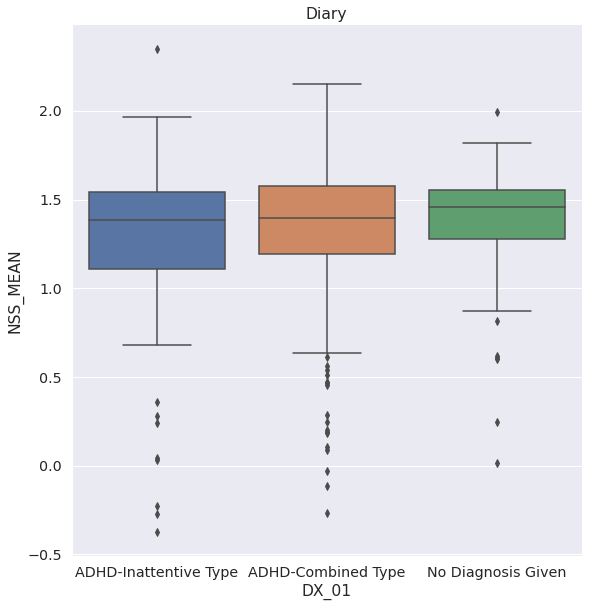

In [18]:
sns.catplot(x='DX_01',y='NSS_MEAN',data=df_wk_diag, height=8, kind='box', order=diagnosis_valid);
plt.title('Diary')

## Fun Fractals

In [19]:
df_ff_filtered = filter_subjects(df_ff, pheno_filtered)
pheno_filtered.set_index('ID').loc[list(df_ff_filtered.index.unique()), 'DX_01'].value_counts()

Total subjects: 99


ADHD-Combined Type       48
ADHD-Inattentive Type    41
No Diagnosis Given       10
Name: DX_01, dtype: int64

Text(0.5, 1.0, 'Fractals')

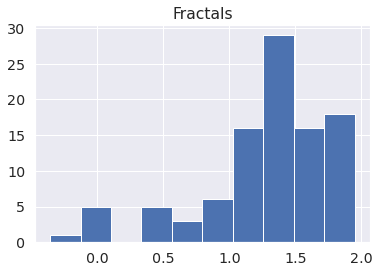

In [20]:
df_ff_filtered['NSS'].groupby('ID').mean().hist()
plt.title('Fractals')

Text(0.5, 1.0, 'Fractals')

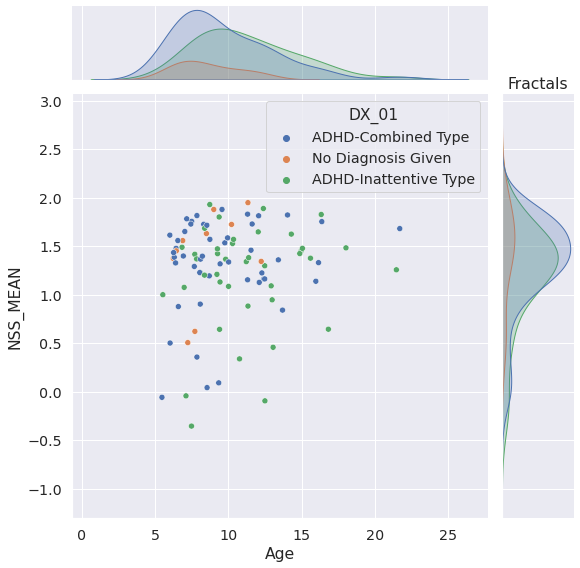

In [21]:
df_ff_diag = pd.merge(df_ff_filtered[~df_ff_filtered.index.duplicated(keep='first')], pheno_filtered[['ID','DX_01','Age']] , on='ID', how='inner').set_index('ID')
sns.jointplot(x='Age',y='NSS_MEAN', hue='DX_01',data=df_ff_diag, height=8);
plt.title('Fractals')

Text(0.5, 1.0, 'Fractals')

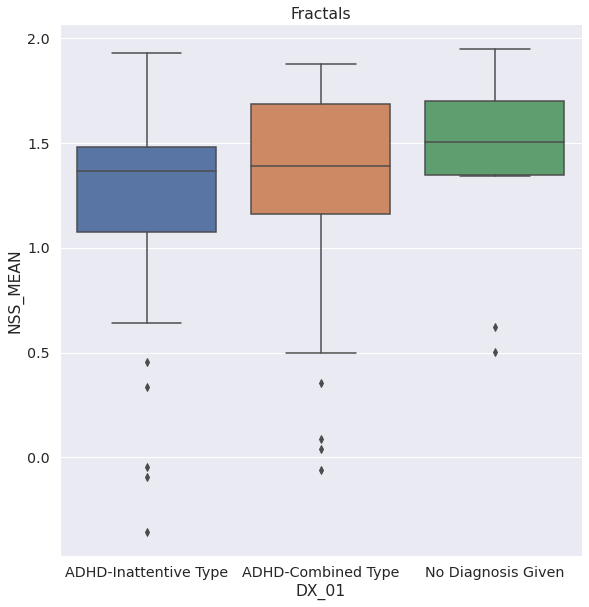

In [22]:
sns.catplot(x='DX_01',y='NSS_MEAN',data=df_ff_diag, height=8, kind='box', order=diagnosis_valid);
plt.title('Fractals')

## Timeseries

In [23]:
# Load Scene Data
scenes_path = './../videos_data/'
scenes_tp = pd.read_csv(os.path.join(scenes_path, 'present', 'The Present_Short-Scenes.csv'), header = 1)
scenes_wk = pd.read_csv(os.path.join(scenes_path, 'diary', 'Diary_of_a_Wimpy_Kid_Trailer-Scenes.csv'), header = 1)
scenes_ff = pd.read_csv(os.path.join(scenes_path, 'fractals', 'Fun_Fractals_v2-Scenes.csv'), header = 1)

In [24]:
def get_longest_scene(df_scenes, i=0):
    aux = df_scenes.sort_values(by='Length (frames)', ascending=False)
    return aux.iloc[i,:]['Start Frame'], aux.iloc[i,:]['End Frame']

In [25]:
get_longest_scene(scenes_ff)

(5025, 7267)

### The present

In [26]:
timeseries_tp = create_timeseries_matrix(df_tp_filtered.reset_index(), metric_val='NSS', nframes = videos_data.loc['Present','NFrames'].astype(int))

In [27]:
def plot_timeseries(timeseries, video_full_name, metric_name = 'NSS'):
    f, ax = plt.subplots(figsize=(15,9))
    m = timeseries.mean(axis=1)
    sm = timeseries.std(axis=1)
    plt.plot(m)
    plt.axhline(y = m.mean(), color = 'r', linestyle = '-.', alpha=0.7)
    plt.fill_between(m.index, m - 1 * sm, m + 1 * sm, alpha=0.2);
    ax.set_ylabel(metric_name, fontsize=15)
    #ax.legend('Frame', fontsize=14);
    plt.title(video_full_name, fontsize=18);
    return None

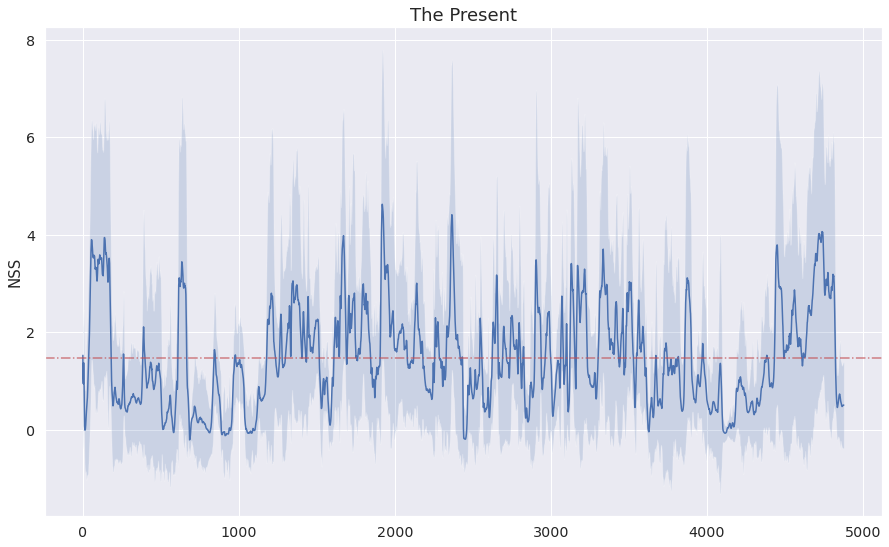

In [28]:
plot_timeseries(timeseries_tp, 'The Present')

In [29]:
def plot_timeseries_grouped(timeseries, df_diagnosis, video_full_name, metric_name = 'NSS', errorbar = True):
    f, ax = plt.subplots(figsize=(15,9))
    lgs = []
    df_grouped = df_diagnosis.reset_index()[['ID','DX_01']].groupby('DX_01')
    for diag, group in df_grouped:
        ids = set(group['ID'].to_list()) & set(timeseries.columns)
        ts = timeseries[ids]
        m = ts.mean(axis=1)
        plt.plot(m)
        lgs.append(diag)
        if errorbar:
            sm = ts.std(axis=1)
            plt.fill_between(m.index, m - 1 * sm, m + 1 * sm, alpha=0.2);
            
    ax.set_ylabel(metric_name, fontsize=15)
    ax.legend(lgs, fontsize=14);
    plt.title(video_full_name, fontsize=18);
    
    return None

In [30]:
timeseries_tp.shape, df_tp_diag.shape

((4877, 122), (141, 10))

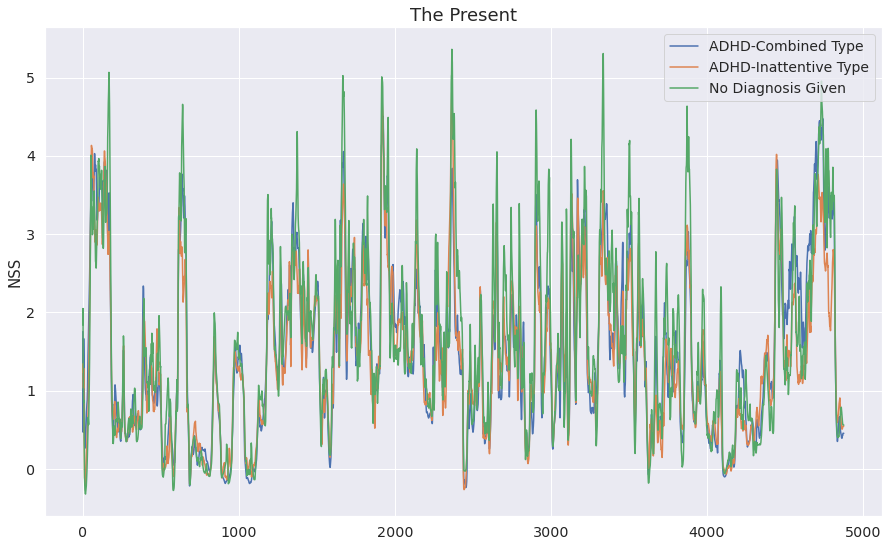

In [31]:
plot_timeseries_grouped(timeseries_tp, df_tp_diag, 'The Present', errorbar = False)

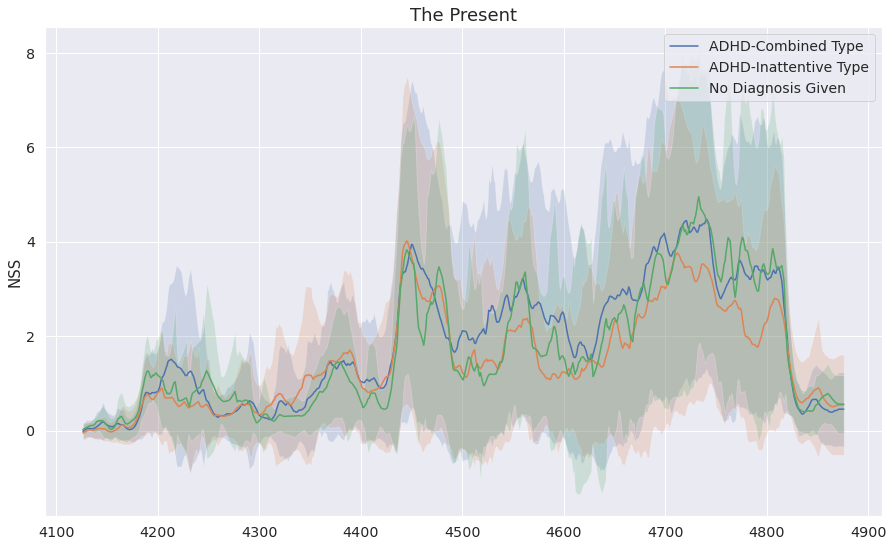

In [32]:
s, e = get_longest_scene(scenes_tp)
plot_timeseries_grouped(timeseries_tp.iloc[s:e,:], df_tp_diag, 'The Present', errorbar = True)

### Diary

In [33]:
timeseries_wk = create_timeseries_matrix(df_wk_filtered.reset_index(), metric_val='NSS', nframes = videos_data.loc['Diary','NFrames'].astype(int))

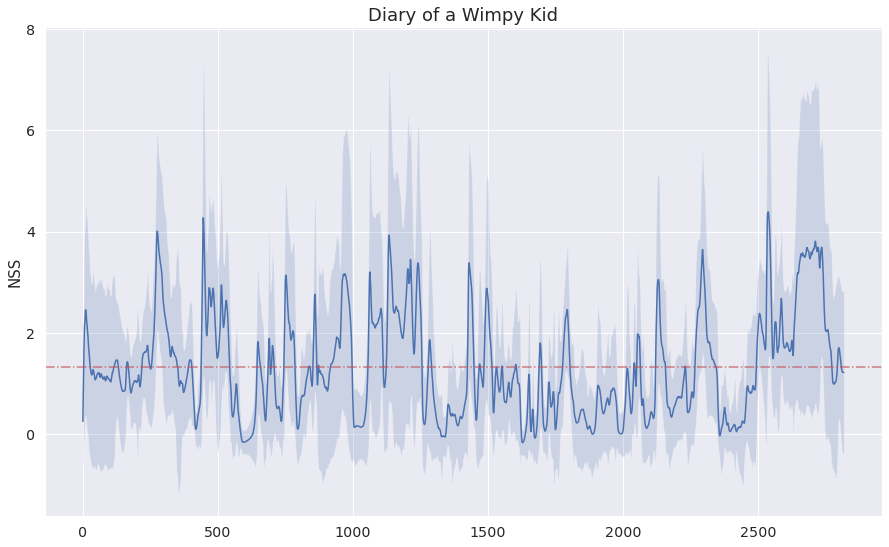

In [34]:
plot_timeseries(timeseries_wk, 'Diary of a Wimpy Kid')

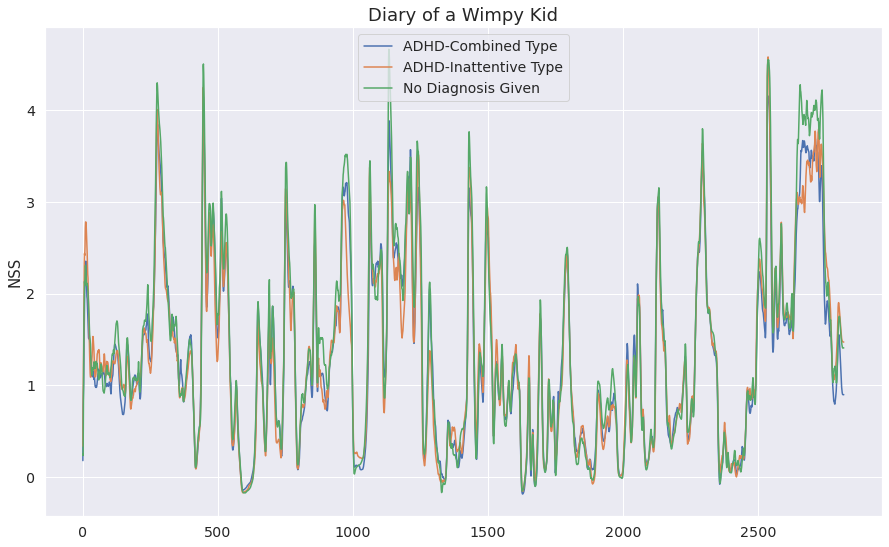

In [35]:
plot_timeseries_grouped(timeseries_wk, df_wk_diag, 'Diary of a Wimpy Kid', errorbar = False)

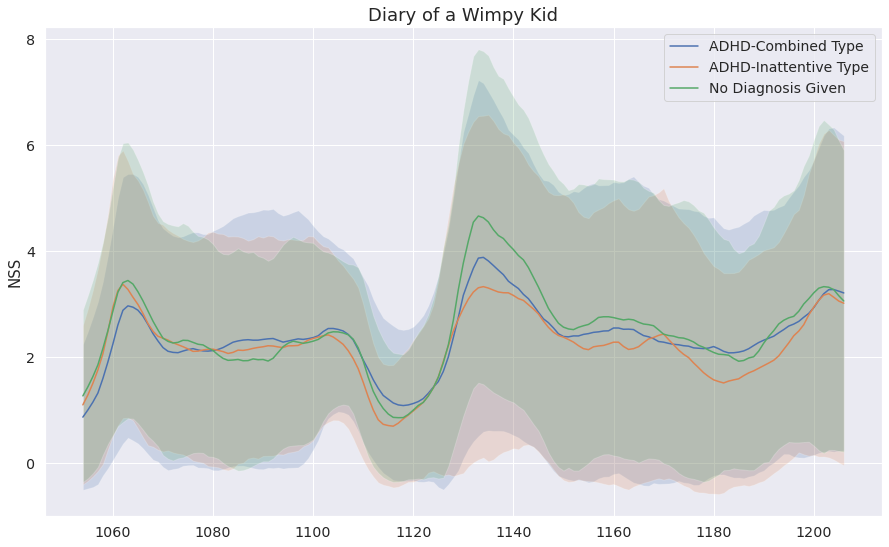

In [36]:
s, e = get_longest_scene(scenes_wk)
plot_timeseries_grouped(timeseries_wk.iloc[s:e,:], df_wk_diag, 'Diary of a Wimpy Kid', errorbar = True)

### Fun with Fractals

In [37]:
timeseries_ff = create_timeseries_matrix(df_ff_filtered.reset_index(), metric_val='NSS', nframes = videos_data.loc['Fractals','NFrames'].astype(int))

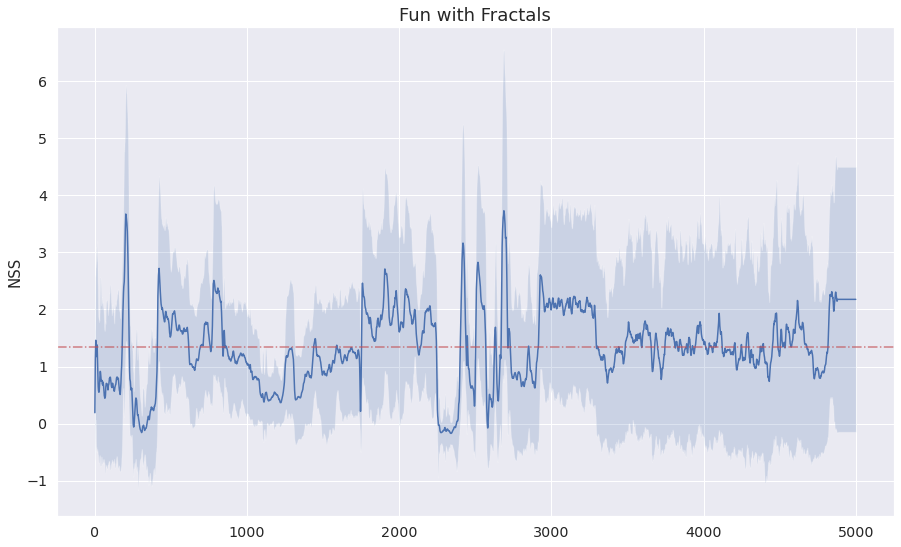

In [38]:
plot_timeseries(timeseries_ff.iloc[:5000,:], 'Fun with Fractals')

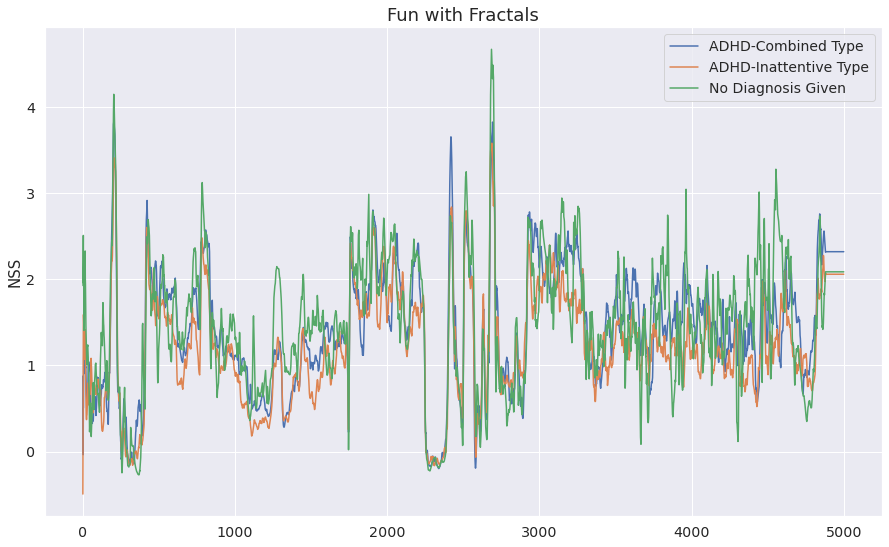

In [39]:
plot_timeseries_grouped(timeseries_ff.iloc[:5000,:], df_ff_diag, 'Fun with Fractals', errorbar = False)

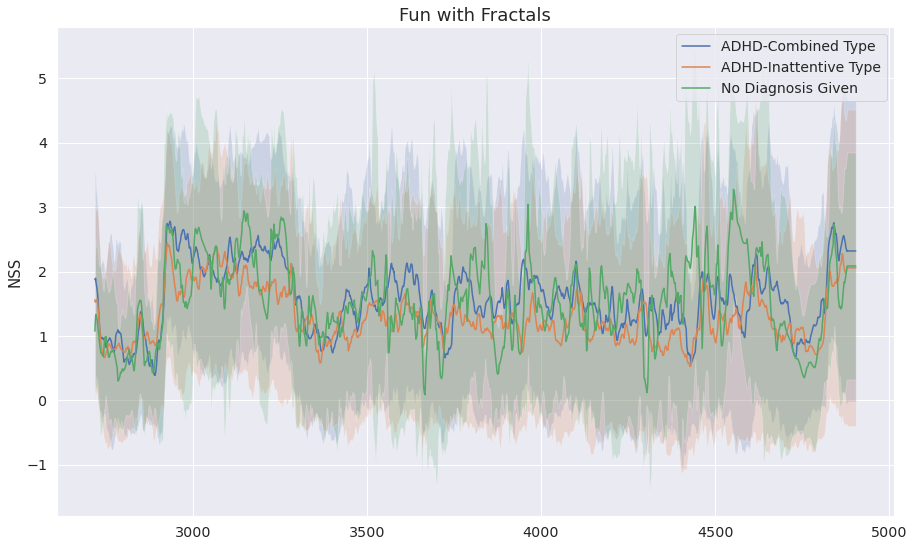

In [40]:
s, e = get_longest_scene(scenes_ff,1)
plot_timeseries_grouped(timeseries_ff.iloc[s:e,:], df_ff_diag, 'Fun with Fractals', errorbar = True)

## Prediction

In [80]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso, LassoCV, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.utils.slope_and_trend import _slope
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.reduce import Tabularizer
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.transformations.panel.compose import ColumnConcatenator

### Diary

In [82]:
data_diag = pheno_filtered.set_index('ID').loc[list(timeseries_wk.T.index), 'DX_01']
ids = data_diag[data_diag != 'ADHD-Combined Type'].index.to_list()
y_labels = pheno_filtered.set_index('ID').loc[ids, 'DX_01']
display(y_labels.value_counts())
# 24 number of frames with nan values
X = from_2d_array_to_nested(timeseries_wk[ids].iloc[24:-24,:].T)
X.shape

ADHD-Inattentive Type    145
No Diagnosis Given       134
Name: DX_01, dtype: int64

(279, 1)

In [83]:
encoder = LabelEncoder()
y = encoder.fit_transform(y_labels)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size = 0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((223, 1), (56, 1), (223,), (56,))

In [84]:
# Dummy Classifier
classifier = make_pipeline(Tabularizer(), RandomForestClassifier())
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.39285714285714285

In [85]:
# Feature extraction
transformer = TSFreshFeatureExtractor(default_fc_parameters="minimal")
extracted_features = transformer.fit_transform(X_train)

Feature Extraction: 100%|██████████| 223/223 [00:00<00:00, 1130.24it/s]


In [86]:
# Random Forest with TS features
classifier = make_pipeline(
    TSFreshFeatureExtractor(show_warnings=False), RandomForestClassifier()
)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

Feature Extraction: 100%|██████████| 56/56 [00:28<00:00,  1.98it/s]


0.5892857142857143

In [87]:
steps = [
    (
        "extract",
        RandomIntervalFeatureExtractor(
            n_intervals="sqrt", features=[np.mean, np.std, _slope]
        ),
    ),
    ("clf", DecisionTreeClassifier()),
]
time_series_tree = Pipeline(steps)

In [88]:
time_series_tree.fit(X_train, y_train)
time_series_tree.score(X_test, y_test)

0.5

In [89]:
# Time Series Forest
tsf = ComposableTimeSeriesForestClassifier(
    estimator=time_series_tree,
    n_estimators=100,
    bootstrap=True,
    oob_score=True,
    random_state=1,
    n_jobs=-1,
)

In [90]:
tsf.fit(X_train, y_train)

if tsf.oob_score:
    print(tsf.oob_score_)

0.5336322869955157


In [91]:
tsf = ComposableTimeSeriesForestClassifier()
tsf.fit(X_train, y_train)
tsf.score(X_test, y_test)

0.5178571428571429

### Diary cut

In [92]:
data_diag = pheno_filtered.set_index('ID').loc[list(timeseries_wk.T.index), 'DX_01']
ids = data_diag[data_diag != 'ADHD-Combined Type'].index.to_list()
y_labels = pheno_filtered.set_index('ID').loc[ids, 'DX_01']
display(y_labels.value_counts())

s, e = get_longest_scene(scenes_wk,1)

# 24 number of frames with nan values
X = from_2d_array_to_nested(timeseries_wk[ids].iloc[s:e,:].T)
X.shape

ADHD-Inattentive Type    145
No Diagnosis Given       134
Name: DX_01, dtype: int64

(279, 1)

In [93]:
encoder = LabelEncoder()
y = encoder.fit_transform(y_labels)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size = 0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((223, 1), (56, 1), (223,), (56,))

In [94]:
classifier = make_pipeline(Tabularizer(), RandomForestClassifier())
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.5892857142857143

In [95]:
# Random Forest with TS features
classifier = make_pipeline(
    TSFreshFeatureExtractor(show_warnings=False), RandomForestClassifier()
)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

Feature Extraction: 100%|██████████| 56/56 [00:02<00:00, 20.76it/s]


0.4642857142857143

In [96]:
# Time Series Forest
tsf = ComposableTimeSeriesForestClassifier(
    estimator=time_series_tree,
    n_estimators=100,
    bootstrap=True,
    oob_score=True,
    random_state=1,
    n_jobs=-1,
)

In [97]:
tsf.fit(X_train, y_train)

if tsf.oob_score:
    print(tsf.oob_score_)

0.45739910313901344


## Merging NSS - ViNet

In [11]:
# ViNet
df_wk2 = pd.read_csv(os.path.join(results_path, 'WK', 'results_nss_wk_vn.csv')) 
df_wk_merged = pd.merge(df_wk_filtered, df_wk2[['ID','FIX_idx','NSS']],  how='left', left_on=['ID','FIX_idx'], right_on = ['ID','FIX_idx'])

NameError: name 'df_wk_filtered' is not defined

In [99]:
df_wk_merged.rename(columns={'NSS_x': 'NSS_dg', 'NSS_y': 'NSS_vn'}, inplace=True)

In [100]:
df_wk_merged

,ID,FIX_idx,NSS_dg,NSS_MEAN,FIX_IN_VID,FLAG,VIDEO_NAME,ET_FILE,FRAME_idx,NSS_vn
0,NDARPE551CK7,1,1.873702,1.658951,420,0,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,5,3.366711
1,NDARPE551CK7,3,1.473133,1.658951,420,0,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,7,3.135148
2,NDARPE551CK7,5,-0.156525,1.658951,420,0,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,10,-0.233512
3,NDARPE551CK7,7,-0.108533,1.658951,420,0,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,15,-0.188848
4,NDARPE551CK7,9,-0.304896,1.658951,420,0,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,21,-0.367512
...,...,...,...,...,...,...,...,...,...,...
201073,NDARTE424BUF,1101,3.604566,1.811118,552,0,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,2793,4.451271
201074,NDARTE424BUF,1103,3.315460,1.811118,552,0,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,2798,4.038130
201075,NDARTE424BUF,1105,2.837397,1.811118,552,0,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,2801,4.417984
201076,NDARTE424BUF,1107,1.606612,1.811118,552,0,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,2807,2.647049


In [101]:
timeseries_wk_vn = create_timeseries_matrix(df_wk_merged, metric_val='NSS_vn', nframes = videos_data.loc['Fractals','NFrames'].astype(int))

In [102]:
data_diag = pheno_filtered.set_index('ID').loc[list(timeseries_wk_vn.T.index), 'DX_01']
ids = data_diag[data_diag != 'ADHD-Combined Type'].index.to_list()
y_labels = pheno_filtered.set_index('ID').loc[ids, 'DX_01']
display(y_labels.value_counts())
# 24 number of frames with nan values
X1 = from_2d_array_to_nested(timeseries_wk[ids].iloc[24:-24,:].T)
X2 = from_2d_array_to_nested(timeseries_wk_vn[ids].iloc[24:-24,:].T)
X1.shape, X2.shape

ADHD-Inattentive Type    145
No Diagnosis Given       134
Name: DX_01, dtype: int64

((279, 1), (279, 1))

In [103]:
X = pd.concat([X1, X2],axis=1)
encoder = LabelEncoder()
y = encoder.fit_transform(y_labels)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size = 0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((223, 2), (56, 2), (223,), (56,))

In [104]:
steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=100)),
]
clf = Pipeline(steps)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5178571428571429

### Cut

### Saliency correlation

***

***
# REVISION DE FRACTALS

In [32]:
metadata = load_metadata()
trials_data = load_trials_data()

In [33]:
data_path = './../data/ETFinalCutSampleEC07/ETFinalCutSample/'
vid_name = 'Fractals'
missing_metadata = []
missing_csv_vid  = []
kkk=[]
for fold_subj in tqdm(sorted(os.listdir(data_path))):
    if fold_subj in list(metadata['ID'].unique()):
        pass
    else:
        missing_metadata.append(fold_subj)
        continue
        
    csv_files    = os.listdir(data_path+fold_subj)
    csv_vid_file = [f for f in csv_files if 'FF' in f]
    if len(csv_vid_file) ==0:
        missing_csv_vid.append(fold_subj)
        continue
        
    et_file      = data_path + fold_subj + '/' + csv_vid_file[0]
    df_et        = pd.read_csv(et_file)
    kkk.append(df_et.iloc[-1,7])
    #frame_timest = videos_data.loc[vid_name,'FramesTimestamps']
    #trial_init   = trials_data.loc[fold_subj].set_index('VideoName').loc[vid_name].Start
    #df_fix, flag = preprocess_fixations_new_dataset(df_et, frame_timest, trial_init)
    #if flag==-1:
    #    continue
    #else:
    #    break
    
    #auc_score, tpr = fixations_subj_auc(df_fix, vid_saliency = saliency, vid_saliency_percentils = sal_perc,
        #                                        trial_resol_width=800, trial_resol_hight=600, npercentils=21)
    
    #results.append((fold_subj, auc_score, len(df_fix), flag, vid_name, et_file, tpr))

  0%|          | 0/994 [00:00<?, ?it/s]

<AxesSubplot:>

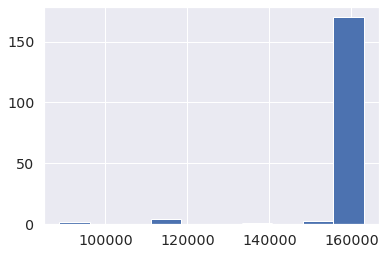

In [34]:
pd.Series(kkk).hist()

In [36]:
trials_data[trials_data.VideoName=='Fractals'].Duration.median()

162987505.0

In [38]:
trials_data[trials_data.VideoName=='Diary'].Duration.describe()

count    2.558000e+03
mean     1.172523e+08
std      4.023326e+06
min      6.007000e+03
25%      1.173898e+08
50%      1.173939e+08
75%      1.173967e+08
max      1.178181e+08
Name: Duration, dtype: float64

In [39]:
trials_data_aux = trials_data.droplevel(1)
trials_data_aux[trials_data_aux.VideoName=='Fractals'].loc[fold_subj].Duration

162987688.0

In [40]:
trials_data_aux[trials_data_aux.VideoName=='Fractals'].loc[fold_subj].Stop - trials_data_aux[trials_data_aux.VideoName=='Fractals'].loc[fold_subj].Start

162987688.0

***
# DEBUG

In [45]:
df_ff_filtereds.shape

(265437, 15)

In [125]:
def create_timeseries_matrix2(df,  nframes, skip_first = 24, metric_val='NSS', interpolation='linear'):
    
    frame_index = list(range(0, nframes))
    dummy_df = pd.DataFrame(pd.Series(frame_index, dtype='int'))
    dummy_df.columns = ['FRAME_idx']
    ts_list = []
    ids_list = []
    for sid in df.ID.unique():
        ts = get_timeseries(df, sid, ind ='FRAME_idx', val=metric_val)
        #print(ts)
        #print(sid)
        #break
        # porque estoy usando 24?
        if ts.FRAME_idx.iloc[0] <= skip_first:
            ts_alineado = dummy_df.merge(ts, left_on = 'FRAME_idx', right_on='FRAME_idx', how='outer')
            ts_alineado[metric_val] = ts_alineado[metric_val].interpolate(interpolation)
            ts_alineado = ts_alineado.set_index('FRAME_idx')#.drop(columns=['FRAME_idx'])
            ts_list.append(ts_alineado)
            ids_list.append(sid)
    
    try:
        df_ts = pd.concat(ts_list,axis=1)
    except Exception as e:
        print(e)
        return ts_list, ids_list
    
    df_ts.columns = ids_list
    return df_ts

In [136]:
df_wk_filtereds.ID.unique()[:10]

array(['NDARFR095UJK', 'NDARGA048BD8', 'NDARJJ343TR0', 'NDARFX710UZA',
       'NDARNK241ZXA', 'NDARGX760NYV', 'NDAREV527ZRF', 'NDARTY636BWN',
       'NDARUZ345THD', 'NDARUC022JWT'], dtype=object)

In [140]:
df_ff_filtereds[df_ff_filtereds.ID=='NDARUC022JWT'].FRAME_idx.isna().sum()

0

In [145]:
df_wk_filtereds_que = df_wk_filtereds[df_wk_filtereds.ID=='NDARFR095UJK'][['FRAME_idx' ,'FIX_ts','NSS']].sort_values(['FRAME_idx'],ascending=True).copy()

In [146]:
df_wk_filtereds_que

,FRAME_idx,FIX_ts,NSS
0,33.0,1370.763,-0.289613
1,45.0,1853.885,-0.289408
2,51.0,2087.130,-0.270845
3,53.0,2203.764,-0.266720
4,58.0,2403.704,0.027191
...,...,...,...
580,NaN,200260.304,0.693869
581,NaN,200810.077,2.836943
582,NaN,201259.917,1.261968
583,NaN,202409.478,0.216175


In [170]:
df_aux       = df_wk_filtereds[df_wk_filtereds.ID=='NDARFR095UJK'].copy()
et_file      = df_aux.ET_FILE.iloc[0]
df_et        = pd.read_csv(os.path.join('./../',et_file[2:]))

In [171]:
df_et

,fix,x,y,subId,trialId,event_len,start_time,end_time
0,-1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,23,171.222,554.394
1,0,"[683.53, 714.94]","[147.19, 144.26]",0,0,2,554.394,587.718
2,-1,[0.0],[0.0],0,0,1,604.389,621.047
3,-1,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]",0,0,5,637.708,720.992
4,0,[626.44],[265.65],0,0,1,720.992,737.666
...,...,...,...,...,...,...,...,...
1223,0,"[296.11, 279.29, 244.64, 224.23, 223.73, 234.2...","[192.85, 179.28, 192.85, 218.14, 185.49, 176.0...",0,0,7,202292.840,202409.478
1224,1,"[262.9, 254.37, 245.44, 247.13, 245.32, 252.29...","[153.62, 151.81, 171.69, 174.58, 164.82, 170.1...",0,0,16,202409.478,202676.034
1225,0,[249.11],[175.22],0,0,1,202676.034,202692.686
1226,1,"[247.49, 246.72, 246.76, 247.87, 247.48, 245.2...","[177.21, 177.46, 179.02, 180.04, 179.78, 180.2...",0,0,15,202692.686,202942.596


In [172]:
frame_timest = videos_data.loc['Diary','FramesTimestamps']
trial_init   = 0
df_fix, flag = preprocess_fixations_new_dataset(df_et, frame_timest, trial_init)
frame_id     = df_fix.frames_seen.apply(lambda x: x[0])
  #print(frame_id.columns)
        #print(frame_id.index)
df_aux       = df_aux.merge(frame_id,how='right',left_on='FIX_idx',right_index=True)    

In [173]:
df_aux

,ID,NSS_MEAN,FIX_IN_VID,FLAG,VIDEO_NAME,ET_FILE,NSS,Sex,Age,SWAN,SWAN_HY,SWAN_IN,FIX_ts,FIX_idx,FRAME_idx,frames_seen
0,NDARFR095UJK,0.63306,585,0,Present,./data/ETFinalCutSample/NDARFR095UJK/NDARFR095...,-0.289613,0,5.452201,0.833333,0.555555,1.111111,1370.763,16,33.0,33
1,NDARFR095UJK,0.63306,585,0,Present,./data/ETFinalCutSample/NDARFR095UJK/NDARFR095...,-0.289408,0,5.452201,0.833333,0.555555,1.111111,1853.885,25,45.0,45
2,NDARFR095UJK,0.63306,585,0,Present,./data/ETFinalCutSample/NDARFR095UJK/NDARFR095...,-0.270845,0,5.452201,0.833333,0.555555,1.111111,2087.130,31,51.0,51
3,NDARFR095UJK,0.63306,585,0,Present,./data/ETFinalCutSample/NDARFR095UJK/NDARFR095...,-0.266720,0,5.452201,0.833333,0.555555,1.111111,2203.764,35,53.0,53
4,NDARFR095UJK,0.63306,585,0,Present,./data/ETFinalCutSample/NDARFR095UJK/NDARFR095...,0.027191,0,5.452201,0.833333,0.555555,1.111111,2403.704,41,58.0,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,NDARFR095UJK,0.63306,585,0,Present,./data/ETFinalCutSample/NDARFR095UJK/NDARFR095...,2.460034,0,5.452201,0.833333,0.555555,1.111111,115992.970,700,2782.0,2782
325,NDARFR095UJK,0.63306,585,0,Present,./data/ETFinalCutSample/NDARFR095UJK/NDARFR095...,-0.068862,0,5.452201,0.833333,0.555555,1.111111,116209.562,702,2787.0,2787
326,NDARFR095UJK,0.63306,585,0,Present,./data/ETFinalCutSample/NDARFR095UJK/NDARFR095...,-0.038061,0,5.452201,0.833333,0.555555,1.111111,116409.484,704,2792.0,2792
327,NDARFR095UJK,0.63306,585,0,Present,./data/ETFinalCutSample/NDARFR095UJK/NDARFR095...,-0.201547,0,5.452201,0.833333,0.555555,1.111111,116642.739,706,2797.0,2797


In [ ]:
dfs_list.append(df_aux)

In [151]:
videos_data.loc['Diary', 'FramesTimestamps'][-1]

117450.66666666666

In [148]:
trials_data.loc['NDARUC022JWT'].set_index('VideoName').loc['Diary'].Duration

117395219.0

In [127]:
ts = get_timeseries(df_wk_filtereds, 'NDARFR095UJK', ind ='FRAME_idx', val='NSS')

In [128]:
ts

,FRAME_idx,NSS
0,33.0,-0.289613
1,45.0,-0.289408
2,51.0,-0.270845
3,53.0,-0.266720
4,58.0,0.027191
...,...,...
580,NaN,0.693869
581,NaN,2.836943
582,NaN,1.261968
583,NaN,0.216175


In [122]:
ppp = df_tp_filtereds.reset_index()
ppp[ppp.reset_index().ID =='NDARFR095UJK'].FRAME_idx

0        33
1        45
2        51
3        53
4        58
       ... 
580    4807
581    4820
582    4831
583    4858
584    4865
Name: FRAME_idx, Length: 585, dtype: int64

In [176]:
timeseries_wk = create_timeseries_matrix2(df_wk_filtereds, metric_val='NSS', nframes = videos_data.loc['Diary','NFrames'].astype(int))

     FRAME_idx       NSS
0           33 -0.289613
1           45 -0.289408
2           51 -0.270845
3           53 -0.266720
4           58  0.027191
..         ...       ...
324       2782  2.460034
325       2787 -0.068862
326       2792 -0.038061
327       2797 -0.201547
328       2804 -0.205465

[329 rows x 2 columns]
NDARFR095UJK
No objects to concatenate


In [177]:
timeseries_wk

([], [])

In [90]:
timeseries_wk

([                NSS
  FRAME_idx          
  0.0             NaN
  1.0             NaN
  2.0        3.264010
  3.0        2.531123
  4.0        1.798235
  ...             ...
  NaN        0.962101
  NaN        0.690919
  NaN        0.437696
  NaN       -0.347030
  NaN       -0.401402
  
  [3038 rows x 1 columns],
                  NSS
  FRAME_idx          
  0.0             NaN
  1.0             NaN
  2.0             NaN
  3.0             NaN
  4.0             NaN
  ...             ...
  NaN        0.307426
  NaN        0.180578
  NaN        0.457163
  NaN        0.392267
  NaN       -0.368479
  
  [3182 rows x 1 columns],
                  NSS
  FRAME_idx          
  0.0             NaN
  1.0             NaN
  2.0             NaN
  3.0             NaN
  4.0             NaN
  ...             ...
  NaN        0.114421
  NaN        0.044174
  NaN       -0.363660
  NaN       -0.390197
  NaN        0.078565
  
  [3040 rows x 1 columns],
                  NSS
  FRAME_idx          
  0.0   

In [84]:
timeseries_wk[0][4]

,NSS
FRAME_idx,
0.0,NaN
1.0,NaN
2.0,NaN
3.0,NaN
4.0,NaN
...,...
NaN,0.264014
NaN,0.343103
NaN,0.413495


In [ ]:
df_tp_filtereds

<AxesSubplot:xlabel='FRAME_idx'>

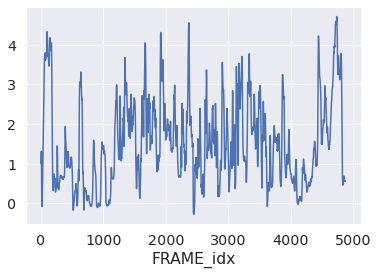

In [60]:
timeseries_tp.mean(axis=1).plot()

In [17]:
# add frames idx (in future plans this should be saved in results)
for vid in videos_df.keys():
    frames_data = videos_data.loc[vid]

    # assing frames --- ESTO LO SAQUE PORQUE LO HICE DE UNA MANERA MAS CONSISTENTE AL GUARDAR LOS VALORES DE CC Y DE NSS EN MAIN_METRICS_EXPLODED.IPYNB
    TIME_BINS, NFRAMES, FPS = frames_data.FramesTimestamps, frames_data.NFrames, frames_data.FPS
    FRAME_DURATION = TIME_BINS[1]
    frames_id = np.digitize(videos_df[vid].FIX_ts, bins=TIME_BINS)
#     videos_df[vid]['FRAME_idx'] = frames_id
    
    if vid == 'Present':
        df_tp['FRAME_idx'] = frames_id
        age_bins = np.digitize(df_tp.Age,bins=[8, 12])
        df_tp['AGE_groups'] = age_bins
        df_tp_age = [df_tp[df_tp['AGE_groups']==i] for i in df_tp.AGE_groups.unique()]
    elif vid == 'Fractals':
        df_ff['FRAME_idx'] = frames_id
        age_bins = np.digitize(df_ff.Age,bins=[8, 12])
        df_ff['AGE_groups'] = age_bins
        df_ff_age = [df_ff[df_ff['AGE_groups']==i] for i in df_ff.AGE_groups.unique()]
    elif vid == 'Diary':
        df_wk['FRAME_idx'] = frames_id
        age_bins = np.digitize(df_wk.Age,bins=[8, 12])
        df_wk['AGE_groups'] = age_bins
        df_wk_age = [df_wk[df_wk['AGE_groups']==i] for i in df_wk.AGE_groups.unique()]
    else:
        pass
    ages = ['0-8', '8-12', '12 and older']

df_tp.head(3)

,ID,NSS_MEAN,FIX_IN_VID,FLAG,VIDEO_NAME,ET_FILE,NSS,Sex,Age,SWAN,SWAN_HY,SWAN_IN,FIX_ts,FIX_idx,FRAME_idx,AGE_groups
0,NDARGX173AC3,1.589683,708,0,Present,./data/ETFinalCutSample/NDARGX173AC3/NDARGX173...,1.415863,1,13.652521,0.611111,0.111111,1.111111,123.708,1,3,2
1,NDARGX173AC3,1.589683,708,0,Present,./data/ETFinalCutSample/NDARGX173AC3/NDARGX173...,0.232432,1,13.652521,0.611111,0.111111,1.111111,365.560,3,9,2
2,NDARGX173AC3,1.589683,708,0,Present,./data/ETFinalCutSample/NDARGX173AC3/NDARGX173...,-0.284955,1,13.652521,0.611111,0.111111,1.111111,565.818,5,14,2


In [18]:
ts_tp = create_timeseries_matrix(df_tp, videos_data.loc['Present'].NFrames.astype(int))

In [19]:
ts_ff = create_timeseries_matrix(df_ff, videos_data.loc['Fractals'].NFrames.astype(int))

In [20]:
ts_wk = create_timeseries_matrix(df_wk, videos_data.loc['Diary'].NFrames.astype(int))

# Using NSS as regression variables
There are some missing subjects after creating the timeseries matrix

In [21]:
ts_tp.columns

Index(['NDARGX173AC3', 'NDARUG492VF0', 'NDARRK135YAZ', 'NDARFB757VY3',
       'NDARYA877HN5', 'NDARHC814ZZL', 'NDARMW088NNR', 'NDARJJ345VHW',
       'NDARYA851GL6', 'NDARMZ477MNH',
       ...
       'NDARAD224CRB', 'NDARLD738DUM', 'NDARKF704MKL', 'NDARMZ687XRR',
       'NDARFX710UZA', 'NDARZW472CCF', 'NDARAE866UVF', 'NDARZV608BL8',
       'NDARAR238RZ8', 'NDARGC559LN8'],
      dtype='object', length=694)

In [22]:
df_data = ts_tp.T.loc[list(set(ts_tp.columns) & set(subjs_all_vids)),:].dropna(axis=1,how='any')
df_data.head()

FRAME_idx,24,25,26,27,28,29,30,31,32,33,...,4867,4868,4869,4870,4871,4872,4873,4874,4875,4876
NDARRU979UBW,-0.268678,-0.258053,-0.247427,-0.236801,-0.226175,-0.215550,-0.204924,-0.194298,-0.183672,-0.173047,...,1.492659,1.492659,1.492659,1.492659,1.492659,1.492659,1.492659,1.492659,1.492659,1.492659
NDARHL684WYU,-0.323677,-0.303571,-0.283466,-0.263361,-0.243256,-0.223151,-0.203046,-0.182940,-0.162835,-0.142730,...,1.054266,1.054266,1.054266,1.054266,1.054266,1.054266,1.054266,1.054266,1.054266,1.054266
NDARNY894TH7,0.988983,1.116812,1.244640,1.372468,1.500297,1.628125,1.886811,2.145497,2.404183,2.662868,...,0.259238,0.280541,0.301843,0.323145,0.344448,0.344448,0.344448,0.344448,0.344448,0.344448
NDARFB969EMV,4.116551,4.999721,5.882891,5.510394,5.137898,4.765401,4.392904,4.020407,3.647911,3.275414,...,1.458547,1.458547,1.458547,1.458547,1.458547,1.458547,1.458547,1.458547,1.458547,1.458547
NDARKD064EVC,-0.299009,-0.297266,-0.295523,-0.293781,-0.292038,-0.293618,-0.295199,-0.296780,-0.298360,-0.299941,...,0.973124,0.973124,0.973124,0.973124,0.973124,0.973124,0.973124,0.973124,0.973124,0.973124


In [23]:
from sklearn.linear_model import Lasso, LassoCV, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

In [24]:
encoder = LabelEncoder()

X = df_data.to_numpy()
y_labels = pheno.set_index('ID').loc[df_data.index,'DX_01']
y = encoder.fit_transform(y_labels)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size = 0.2, shuffle=True)

In [25]:
encoder.classes_

array(['ADHD-Combined Type', 'ADHD-Inattentive Type',
       'No Diagnosis Given'], dtype=object)

In [26]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

0.36619718309859156


<AxesSubplot:>

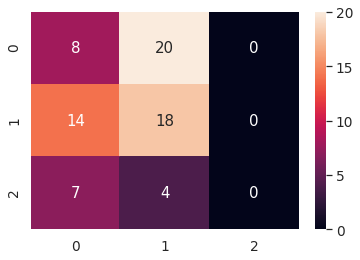

In [27]:
y_pred = rfc.predict(X_test)
print(accuracy_score(y_test, y_pred))
cf = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(cf, annot=True)

In [28]:
ids_2class = df[df['DX_01']!='ADHD-Combined Type'].index

In [29]:
encoder2 = LabelEncoder()

aux = df_data[df_data.index.isin(ids_2class)]
X = aux.to_numpy()
y_labels = pheno.set_index('ID').loc[aux.index,'DX_01']
y = encoder2.fit_transform(y_labels)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size = 0.2, shuffle=True)

ridge = RidgeClassifier(class_weight='balanced')
ridge.fit(X_train, y_train)

cf = confusion_matrix(y_test, ridge.predict(X_test))

array([[27,  5],
       [11,  0]])

## Using longer scenes

In [30]:
scenes_tp = pd.read_csv('./videos_data/present/The Present_Short-Scenes.csv', header =1).sort_values(axis=0, by='Length (frames)', ascending=False)
scenes_tp.head()

,Scene Number,Start Frame,Start Timecode,Start Time (seconds),End Frame,End Timecode,End Time (seconds),Length (frames),Length (timecode),Length (seconds)
54,55,4126,00:02:51.917,171.917,4877,00:03:23.208,203.208,751,00:00:31.292,31.292
5,6,605,00:00:25.208,25.208,830,00:00:34.583,34.583,225,00:00:09.375,9.375
0,1,0,00:00:00.000,0.000,174,00:00:07.250,7.250,174,00:00:07.250,7.250
13,14,1222,00:00:50.917,50.917,1391,00:00:57.958,57.958,169,00:00:07.042,7.042
53,54,3966,00:02:45.250,165.250,4126,00:02:51.917,171.917,160,00:00:06.667,6.667


In [31]:
encoder2 = LabelEncoder()

aux = df_data[df_data.index.isin(ids_2class)]
X = aux.iloc[:,4126:4877].to_numpy()
#X = aux.iloc[:,605:830].to_numpy()
y_labels = pheno.set_index('ID').loc[aux.index,'DX_01']
y = encoder2.fit_transform(y_labels)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size = 0.2, shuffle=True)

model = RidgeClassifier(class_weight='balanced')
model.fit(X_train, y_train)

#confusion_matrix(y_test, model.predict(X_test))
cross_val_score(model, X, y, scoring='balanced_accuracy',cv=3)

array([0.52410901, 0.69977802, 0.52663707])

In [32]:
clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=4))
cross_val_score(clf, X, y, scoring='f1', cv=4)

array([0.125     , 0.11111111, 0.125     , 0.14285714])

# Clustering

In [12]:
videos_data

,Video,Duration(s),NFrames,FPS,Resolution,Width,Height,FramesTimestamps,VideoSaliency,VideoSaliencyNOcb,VideoSalPercentils,VideoSalPercentilsNOcb,Short Name
VideoName,,,,,,,,,,,,,
Diary,Diary_of_a_Wimpy_Kid_Trailer.mp4,117,2817.0,24.0,"(346, 640)",640.0,346.0,"[0.0, 41.708333333333336, 83.41666666666667, 1...",Diary_of_a_Wimpy_Kid_Trailer_saliency_cb.npy,Diary_of_a_Wimpy_Kid_Trailer_saliency.npy,Diary_of_a_Wimpy_Kid_Trailer_saliency_cb_perce...,Diary_of_a_Wimpy_Kid_Trailer_saliency_percenti...,WK
Fractals,Fun_Fractals_v2.mp4,274,8220.0,30.0,"(360, 640)",640.0,360.0,"[0.0, 33.36666666666667, 66.73333333333333, 10...",Fun_Fractals_v2_saliency_cb.npy,Fun_Fractals_v2_saliency.npy,Fun_Fractals_v2_saliency_cb_percentils.npy,Fun_Fractals_v2_saliency_percentils.npy,FF
Present,The Present_Short.mp4,203,4877.0,24.0,"(720, 1280)",1280.0,720.0,"[0.0, 41.666666666666664, 83.33333333333333, 1...",The Present_Short_saliency_cb.npy,The Present_Short_saliency.npy,The Present_Short_saliency_cb_percentils.npy,The Present_Short_saliency_percentils.npy,TP
Despicable,Three_Little_Kittens_Despicable_Me.mp4,170,4266.0,25.0,"(336, 624)",624.0,336.0,"[0.0, 40.0, 80.0, 120.0, 160.0, 200.0, 240.0, ...",Three_Little_Kittens_Despicable_Me_saliency_cb...,Three_Little_Kittens_Despicable_Me_saliency.npy,Three_Little_Kittens_Despicable_Me_saliency_cb...,Three_Little_Kittens_Despicable_Me_saliency_pe...,DM
